# Saving and Loading Models

In this notebook, I'll show you how to save and load models with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

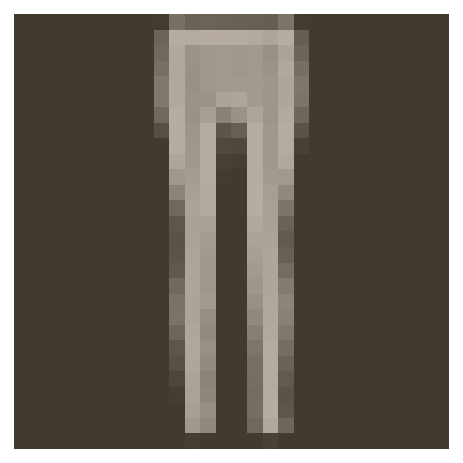

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

# Train a network

To make things more concise here, I moved the model architecture and training code from the last part to a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [4]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.721..  Test Loss: 1.012..  Test Accuracy: 0.630
Epoch: 1/2..  Training Loss: 1.053..  Test Loss: 0.746..  Test Accuracy: 0.725
Epoch: 1/2..  Training Loss: 0.878..  Test Loss: 0.693..  Test Accuracy: 0.719
Epoch: 1/2..  Training Loss: 0.802..  Test Loss: 0.632..  Test Accuracy: 0.757
Epoch: 1/2..  Training Loss: 0.749..  Test Loss: 0.618..  Test Accuracy: 0.759
Epoch: 1/2..  Training Loss: 0.697..  Test Loss: 0.594..  Test Accuracy: 0.776
Epoch: 1/2..  Training Loss: 0.703..  Test Loss: 0.580..  Test Accuracy: 0.774
Epoch: 1/2..  Training Loss: 0.667..  Test Loss: 0.547..  Test Accuracy: 0.791
Epoch: 1/2..  Training Loss: 0.626..  Test Loss: 0.554..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.661..  Test Loss: 0.532..  Test Accuracy: 0.807
Epoch: 1/2..  Training Loss: 0.630..  Test Loss: 0.546..  Test Accuracy: 0.804
Epoch: 1/2..  Training Loss: 0.573..  Test Loss: 0.510..  Test Accuracy: 0.808
Epoch: 1/2..  Training Loss: 0.624..  Test Loss: 0.5

## Saving and loading networks

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [6]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [7]:
torch.save(model.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [8]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

In [9]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

In [10]:
# Try this
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

In [11]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints. 

In [12]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [13]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
